# PyDMD

## Tutorial 14: Demonstrating the optDMD and BOP-DMD

In this tutorial we go over the Bagging-Optimized Dynamic Mode Decomposition (BOP-DMD) and Optimized Dynamic Mode Decomposition (optDMD) methods. Note, that there are two optDMDs and we refer to the one by Ashkham and Kutz (2018) in this tutorial. The optDMD and BOP-DMD are effectively the same method, but with the BOP-DMD implementing a statistical bagging of optDMD fits and aggregating the results.

1) optDMD: Provides an optimized framework for solving the DMD regressions that may come from unevenly spaced time snapshots. 

2) The BOP-DMD takes advantage of this property and solves the DMD using statistical bagging (i.e., randomly selected ensembles) for constructing the DMD.

The advantages of the combined BOP-DMD are: 
- The additional ability to provide uncertainty estimates in the solutions, including uncertainty in the spatial modes, eigenvalues, and amplitudes
- More robustly fitting noisy data.

Citations:

- **optimized Dynamic Mode Decomposition (optDMD)**: Askham, T., & Kutz, J. N. (2018). Variable projection methods for an optimized dynamic mode decomposition. SIAM Journal on Applied Dynamical Systems, 17(1), 380–416. https://doi.org/10.1137/M1124176

- **Bagging, Optimized Dynamic Mode Decomposition (BOP-DMD)**: Sashidhar, D., & Kutz, J. N. (2022). Bagging, optimized dynamic mode decomposition for robust, stable forecasting with spatial and temporal uncertainty quantification. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 380(2229). https://doi.org/10.1098/rsta.2021.0199

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
import pydmd
from pydmd.bopdmd import BOPDMD
from pydmd.bopdmd import BOPDMD
from pydmd import DMD
from pydmd.plotter import plot_eigs
import scipy
import copy

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def relative_error(xprime, x):
    return np.linalg.norm(xprime - x) / np.linalg.norm(x)

## Setting up the toy data

The toy data is exactly the same as in tutorial 2 to provide a direct comparison. The example is a single two-dimensional spatial mode modified by a temporal oscillation with period of 4 that decays towards zero amplitude with time.

Two versions of the data are created as a convenience: a 3d array of 2d spatial snapshots along a time dimension and a 2d array where the spatial dimensions have been flattened down. This is necessary because PyDMD classes expect data of the form `len(samples) x len(time)`.

The data are subdivided into training data and forecast data, as this represents real world use cases for fitting and forecasting. 

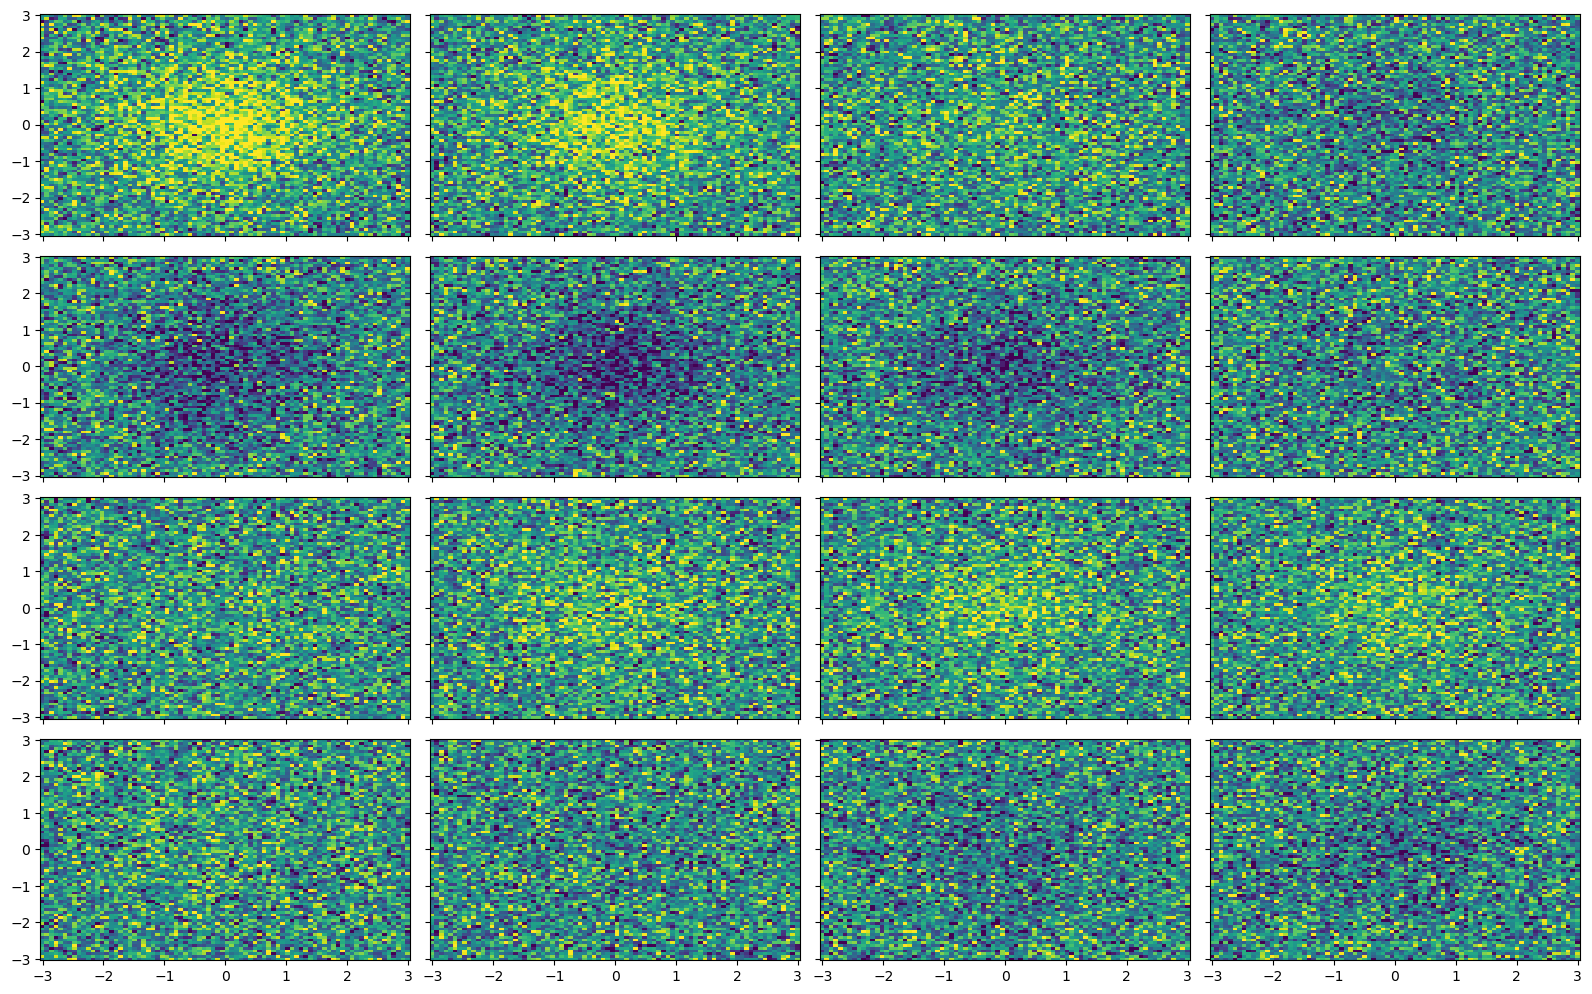

In [4]:
x1 = np.linspace(-3, 3, 80)
x2 = np.linspace(-3, 3, 80)
x1grid, x2grid = np.meshgrid(x1, x2)

# Set the random seed for reproducibility
seed = 1
sigma = 1

time_forecast = np.arange(6 + 0.4, 18 + 0.4, 0.4)
time = np.arange(0, 6 + 0.4, 0.4)
num_time_samples = len(time)
true_eigenvalues = (-.115 - 1j) * np.pi / 2

spatial_modes = 2 / np.cosh(x1grid) / np.cosh(x2grid) 
data_clean = spatial_modes[:, :, np.newaxis] * np.exp(true_eigenvalues * time)
data_forecast = spatial_modes[:, :, np.newaxis] * np.exp(true_eigenvalues * time_forecast)

rng = np.random.default_rng(seed)
noise = rng.normal(0, sigma, (x1grid.shape[0], x1grid.shape[1], num_time_samples))
snapshots_2d = data_clean + noise

# PyDMD expects the data to be 2-dimensional, with shape len(space) x len(time)
snapshots_1d = snapshots_2d.reshape(x1grid.shape[0] * x1grid.shape[1], num_time_samples)

fig, axes = plt.subplots(4, 4, figsize=(16, 10), sharex=True, sharey=True)
for ntime, _ in enumerate(time):
    ax = axes.flatten()[ntime]
    ax.pcolor(x1grid, x2grid, snapshots_2d[:, :, ntime].real, vmin=-2, vmax=2)
fig.tight_layout()

## Fitting and forecasting

Three methods are compared:
1) exact DMD with the optDMD solution
2) optDMD (note, different "optimized" DMD than above)
3) BOP-DMD

All methods are fit through the same syntax, but vary in how the forecasted period is represented.

To reiterate, PyDMD objects expect data of the shape len(space) x len(time), so we have to use the data in which the spatial dimensions collapsed down to a single dimension. After fitting the training data, the data are then forecasted to the forecast period.

In [5]:
optdmd = BOPDMD(svd_rank=1, num_trials=0)
bopdmd = BOPDMD(svd_rank=1, num_trials=50)
dmd = DMD(svd_rank=1, tlsq_rank=2, exact=True, opt=True)

optdmd.fit(snapshots_1d, time)
bopdmd.fit(snapshots_1d, time)
dmd.fit(snapshots_1d)

# Recovering the reconstruction uncertainty is most straight forward using
# the `forecast` method.
reconstruction_mean, reconstruction_variance = bopdmd.forecast(time)

# Forecast the forecast period with BOP-DMD
forecast_mean, forecast_variance = bopdmd.forecast(time_forecast)

# It is necessary to deepcopy the dmd object when generating
# the dmd forecast without overwriting the reconstruction.
dmd_forecast = copy.deepcopy(dmd)
dmd_forecast.dmd_time['t0'] = dmd.dmd_time['tend'] + dmd.dmd_time['dt']
dmd_forecast.dmd_time['tend'] *= 3

The optDMD and BOP-DMD are rooted in the same class. For this generalized class:
- The number of trials, `num_trials`, specifies the number of ensemble members to use in the bagging step of the BOP-DMD.
- The optDMD is the default method when calling BOPDMD as the 'num_trials' keyword defaults to 0.
- `trial_size` determines how much of the total data is used for each ensemble member.

For the DMD we follow Tutorial 2 for consistency in understanding the differences between these methods.

Finally, the optDMD/BOP-DMD methods do not need to have evenly spaced data. e.g., randomly chosen snapshots could be dropped (for example representing a case where observational instruments fail) and the data could still be fit.

In [6]:
optdmd_bad_data_demo = BOPDMD(svd_rank=1, num_trials=0)
index_to_keep = np.array([0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15])
optdmd_bad_data_demo.fit(snapshots_1d[:, index_to_keep], time[index_to_keep])

# Demonstrate the robustness of the fit using the error in eigenvalues
re = relative_error(
    optdmd_bad_data_demo.eigs,
    true_eigenvalues
)

print('Eigenvalue error in bad data demonstration = {:.4f}'.format(re))

Eigenvalue error in bad data demonstration = 0.0007


The optDMD is quite robust in regards to unevenly spaced data.

## Evaluations

### Eigenvalues and Time Dynamics

Text(0.5, 1.0, 'Eigenvalues of DMD, optDMD, BOPDMD')

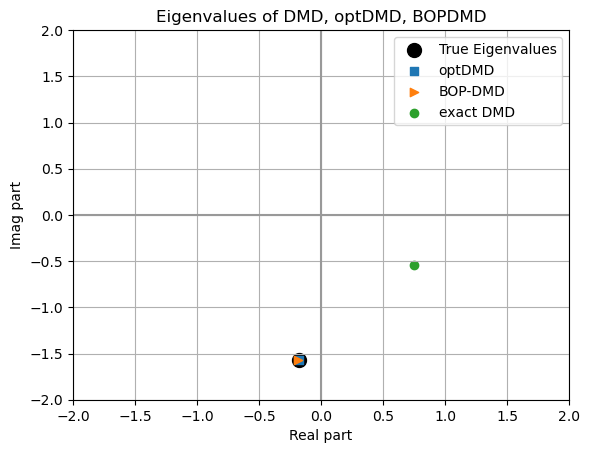

In [7]:
fig, ax = plt.subplots(1, 1)
ax.scatter(true_eigenvalues.real, true_eigenvalues.imag, 100, label='True Eigenvalues', color='k')
ax.scatter(np.real(optdmd.eigs), np.imag(optdmd.eigs), label='optDMD', marker='s')
ax.scatter(np.real(bopdmd.eigs), np.imag(bopdmd.eigs), label='BOP-DMD', marker='>')
ax.scatter(np.real(dmd.eigs), np.imag(dmd.eigs), label='exact DMD')
ax.set_xlabel('Real part')
ax.set_ylabel('Imag part')
ax.legend()
ax.set_ylim(-2, 2)
ax.set_xlim(-2, 2)
ax.grid()
ax.axhline(0, color='0.6')
ax.axvline(0, color='0.6')
ax.set_title('Eigenvalues of DMD, optDMD, BOPDMD')

The optDMD and BOP-DMD recover the true eigenvalues. It is unclear what is driving the difference in eigenvalues between the DMD methods.

One of the main advantages of the BOP-DMD is the ability to provide uncertainties on the fit. Here, the eigenvalue (and thus time dyanmic) uncertainties can be recovered.


In [8]:
print('Uncertainty in the BOPDMD eigenvalues={:.02f}'.format(bopdmd.eigenvalues_std[0]))

# Compare to the eigenvalue error
re = relative_error(
    bopdmd.eigs,
    true_eigenvalues
)
print('Error in the BOPDMD eigenvalues={:.03f}'.format(re))

Uncertainty in the BOPDMD eigenvalues=0.02
Error in the BOPDMD eigenvalues=0.002


### Time Dynamics

All DMD classes recover the time dynamics, but the DMD appears to have a phase offset. In contrast, the BOP-DMD and optDMD recover these dyanmics almost exactly. The time dynamics can be recovered directly by normalizing the `dyanmics` using the `amplitudes`.

Text(0, 0.5, 'Normalized Dynamics (-)')

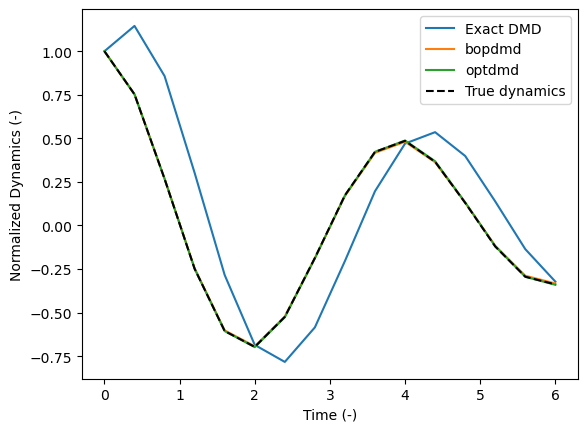

In [9]:
plt.plot(time, dmd.dynamics.real.T / dmd.amplitudes.real, label='Exact DMD')
plt.plot(time, bopdmd.dynamics.real.T / bopdmd.amplitudes.real, label='bopdmd')
plt.plot(time, optdmd.dynamics.real.T / optdmd.amplitudes.real, label='optdmd')
plt.plot(time, np.exp(true_eigenvalues * time).real, 'k--', label='True dynamics')
plt.legend()
plt.gca().set_xlabel('Time (-)')
plt.gca().set_ylabel('Normalized Dynamics (-)')

The average time dynamics of the entire system can also be recovered by averaging the spatial modes for each time step. This roughly corresponds to the two-dimensional integral from Tutorial 2. The forecasted period is also examined.

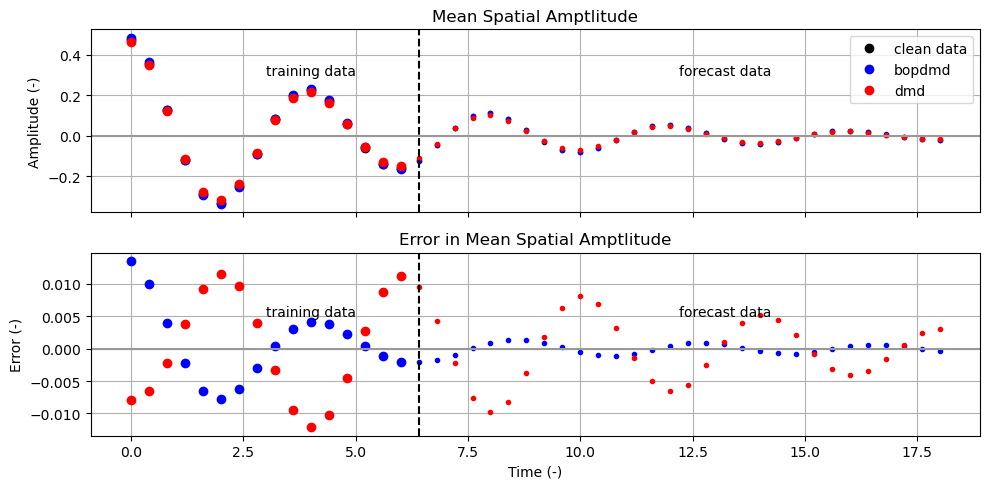

In [10]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
ax = axes[0]

ax.plot(
    time, data_clean.mean(axis=(0, 1)).real,
    label='clean data', color='k', marker='o', ls='None'
)
ax.plot(
    time_forecast, data_forecast.mean(axis=(0, 1)).real,
    color='k', marker='.', ls='None'
)
ax.plot(
    time, bopdmd.reconstructed_data.mean(axis=0).real,
    label='bopdmd', color='b', marker='o', ls='None'
)
ax.plot(
    time_forecast, forecast_mean.mean(axis=0).real,
    color='b', marker='.', ls='None'
)

ax.plot(
    time, dmd.reconstructed_data.mean(axis=0).real,
    label='dmd', color='r', marker='o', ls='None'
)
ax.plot(
    time_forecast, dmd_forecast.reconstructed_data.mean(axis=0).real,
    color='r', marker='.', ls='None'
)
ax.legend()
ax.set_ylabel('Amplitude (-)')
ax.set_title('Mean Spatial Amptlitude')
ax.axhline(0, color='0.6')
ax.grid()
ax.axvline(time_forecast[0], ls='--', color='k')
ax.text(
    np.mean(time_forecast), 0.3, 'forecast data',
    transform=ax.transData
)
ax.text(
    np.mean(time), 0.3, 'training data',
    transform=ax.transData
)

ax = axes[1]
ax.plot(
    time, bopdmd.reconstructed_data.mean(axis=0).real - data_clean.mean(axis=(0, 1)).real,
    color='b', marker='o', ls='None'
)
ax.plot(
    time_forecast, forecast_mean.mean(axis=0).real - data_forecast.mean(axis=(0, 1)).real,
    color='b', marker='.', ls='None'
)
ax.plot(
    time, dmd.reconstructed_data.mean(axis=0).real - data_clean.mean(axis=(0, 1)).real,
    color='r', marker='o', ls='None'
)
ax.plot(
    time_forecast, dmd_forecast.reconstructed_data.mean(axis=0).real - data_forecast.mean(axis=(0, 1)).real,
    color='r', marker='.', ls='None'
)
ax.set_ylabel('Error (-)')
ax.set_xlabel('Time (-)')
ax.set_title('Error in Mean Spatial Amptlitude')
ax.axhline(0, color='0.6')
ax.grid()
ax.axvline(time_forecast[0], ls='--', color='k')
ax.text(
    np.mean(time_forecast), 0.005, 'forecast data',
    transform=ax.transData
)
ax.text(
    np.mean(time), 0.005, 'training data',
    transform=ax.transData
)

fig.tight_layout()

Both the BOP-DMD and DMD recover the training and forecasted data with high fidelity, which can be quantified:

In [11]:
re = relative_error(
    dmd_forecast.reconstructed_data.reshape(
        x1grid.shape[0], x1grid.shape[1], len(time_forecast)
    ),
    data_forecast
)
print('Relative Error of the DMD forecast: {:0.2f}'.format(re))

Relative Error of the DMD forecast: 0.57


In [12]:
re = relative_error(
    forecast_mean.reshape(
        x1grid.shape[0], x1grid.shape[1], len(time_forecast)
    ),
    data_forecast
)
print('Relative Error of the BOP-DMD forecast: {:0.2f}'.format(re))

Relative Error of the BOP-DMD forecast: 0.58


The BOP-DMD just barely outperforms the DMD when evaluating a forecasted period. Note: the relative improvement depends on the level of noise and the DMD can even out perform the BOP-DMD in some cases.

### Spatial Modes

In most real-world cases we don't have the actual underlying modes to compare to. However, with the toy data we can see how well the spatial mode was recovered.

Text(0.5, 0, 'Dim 1 (-)')

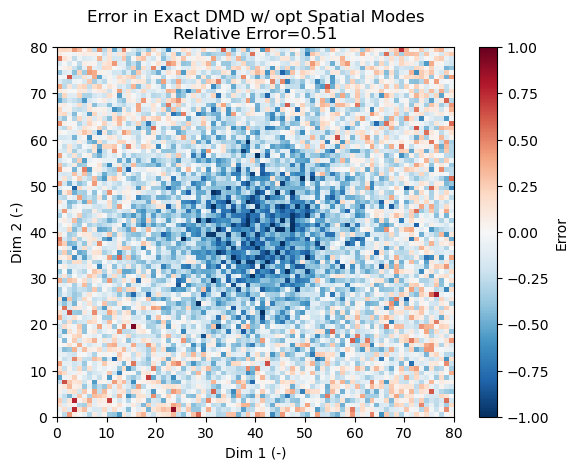

In [13]:
dmd_spatial_modes = dmd.modes.reshape(x1grid.shape).real * dmd.amplitudes.real

fig, ax = plt.subplots(1, 1)
c = ax.pcolormesh(dmd_spatial_modes - spatial_modes, vmin=-sigma, vmax=sigma, cmap='RdBu_r')
cbar = fig.colorbar(c)
cbar.set_label('Error')
ax.set_title(
    'Error in Exact DMD w/ opt Spatial Modes\nRelative Error={:.2f}'.format(
        relative_error(dmd_spatial_modes, spatial_modes)
    )
)
ax.set_ylabel('Dim 2 (-)')
ax.set_xlabel('Dim 1 (-)')

The DMD has some issues recovering the spatial modes, as the errors exhibit a spatial bias.

Text(0.5, 0, 'Dim 1 (-)')

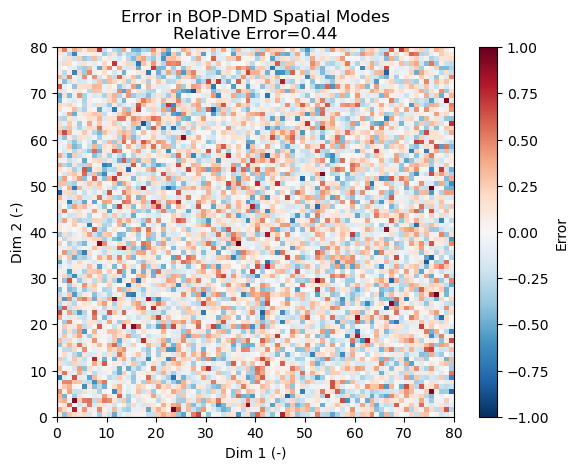

In [14]:
bopdmd_spatial_modes = bopdmd.modes.reshape(x1grid.shape).real * bopdmd.amplitudes.real

fig, ax = plt.subplots(1, 1)
c = ax.pcolormesh(bopdmd_spatial_modes - spatial_modes, vmin=-sigma, vmax=sigma, cmap='RdBu_r')
cbar = fig.colorbar(c)
cbar.set_label('Error')
ax.set_title(
    'Error in BOP-DMD Spatial Modes\nRelative Error={:.2f}'.format(
        relative_error(bopdmd_spatial_modes, spatial_modes)
    )
)
ax.set_ylabel('Dim 2 (-)')
ax.set_xlabel('Dim 1 (-)')

The BOP-DMD spatial mode error is effectively flat, with just random white noise corrupting the spatial modes. The relative error in the spatial modes is slightly smaller than for the DMD.

### Spatial Mode uncertainty

One of the major features of BOP-DMD is the ability to quantify uncertainty in the temporal and spatial modes. The below shows the uncertainty in the  

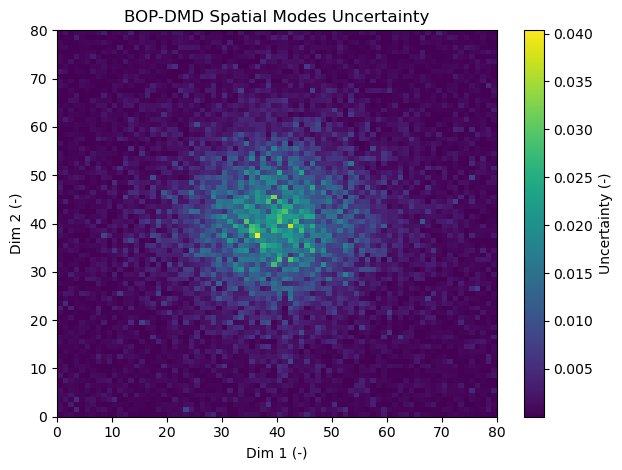

In [15]:
fig, ax = plt.subplots(1, 1)
c = ax.pcolormesh(reconstruction_variance.mean(axis=1).reshape((x1grid.shape[0], x1grid.shape[1])))
cbar = fig.colorbar(c)
cbar.set_label('Uncertainty (-)')
ax.set_title('BOP-DMD Spatial Modes Uncertainty')
ax.set_ylabel('Dim 2 (-)')
ax.set_xlabel('Dim 1 (-)')
fig.tight_layout()

And the uncertainty is largest in the center of the spatial domain (although the magnitude of the uncertainty is perhaps a bit unbelievable given how noisy the system is). However, it is worth nothing that the uncertainty is much smaller than the error, potentially revealing an underestimate of the true uncertainty in the system.